In [5]:
import dask.dataframe as dd

splits = {'train': 'data/train-*-of-*.parquet', 'val': 'data/val-*-of-*.parquet'}
val_ddf = dd.read_parquet("hf://datasets/PoolC/5-fold-clone-detection-600k-5fold/" + splits["val"])


In [6]:
# save the data
df = val_ddf.compute()


In [ ]:
df.to_parquet("../data/val/clone-detection-600k-5fold.parquet") 


# RECREATING THE WORK OF RAHAMAN ET AL

In [79]:
from dfg_generator import DFG_python, tree_to_token_index, remove_comments_and_docstrings, index_to_code_token
import tree_sitter_python as tspython

from tree_sitter import Language, Parser
PY_LANGUAGE = Language(tspython.language())
dfg_function={
    'python':DFG_python,
    # 'java':DFG_java,
    # 'ruby':DFG_ruby,
    # 'go':DFG_go,
    # 'php':DFG_php,
    # 'javascript':DFG_javascript
}
parsers={}        
for lang in dfg_function:
    LANGUAGE = Language(tspython.language())
    parser = Parser(PY_LANGUAGE)
    parser = [parser,dfg_function[lang]]    
    parsers[lang]= parser


def get_dfg(code_snippet,parser):
    try:
        code = remove_comments_and_docstrings(code_snippet)
    except:
        code = code_snippet
    if True:
        tree = parser[0].parse(code.encode())
        root_node = tree.root_node  
        tokens_index=tree_to_token_index(root_node)     
        code=code.split('\n')
        code_tokens=[index_to_code_token(x,code) for x in tokens_index]  
        index_to_code={}
        for idx,(index,code) in enumerate(zip(tokens_index,code_tokens)):
            index_to_code[index]=(idx,code)  
        DFG,_=parser[1](root_node,index_to_code,{}) 
        DFG=sorted(DFG,key=lambda x:x[1])
        indexs=set()
        for d in DFG:
            if len(d[-1])!=0:
                indexs.add(d[1])
            for x in d[-1]:
                indexs.add(x)
        new_DFG=[]
        for d in DFG:
            if d[1] in indexs:
                new_DFG.append(d)
        dfg=new_DFG
    return dfg, code_tokens



# store the dfg and code tokens for each code snippet
df['dfg'], df['code_tokens'] = zip(*df['code'].apply(lambda x: get_dfg(x, parsers['python'])))
df = df.compute()



[('add_list', 1, 'comesFrom', [], []),
 ('a', 3, 'comesFrom', [], []),
 ('b', 5, 'comesFrom', [], []),
 ('a', 10, 'comesFrom', ['a'], [3]),
 ('i', 12, 'comesFrom', ['i'], [20]),
 ('b', 15, 'comesFrom', ['b'], [5]),
 ('i', 17, 'comesFrom', ['i'], [20]),
 ('i', 20, 'computedFrom', ['range', 'len', 'a'], [22, 24, 26]),
 ('range', 22, 'comesFrom', [], []),
 ('len', 24, 'comesFrom', [], []),
 ('a', 26, 'comesFrom', ['a'], [3]),
 ('abc',
  30,
  'computedFrom',
  ['add_list', '1', '2', '3', '4', '5', '6'],
  [32, 35, 37, 39, 43, 45, 47]),
 ('add_list', 32, 'comesFrom', ['add_list'], [1]),
 ('1', 35, 'comesFrom', [], []),
 ('2', 37, 'comesFrom', [], []),
 ('3', 39, 'comesFrom', [], []),
 ('4', 43, 'comesFrom', [], []),
 ('5', 45, 'comesFrom', [], []),
 ('6', 47, 'comesFrom', [], []),
 ('abc', 52, 'comesFrom', ['abc'], [30])]

In [4]:
import tree_sitter_python as tspython
from tree_sitter import Language, Parser, Node
import plotly.graph_objects as go
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

def plot_tree_sitter_graph(example_code):
    # Initialize the parser
    PY_LANGUAGE = Language(tspython.language())
    parser = Parser(PY_LANGUAGE)


    # Parse the example code
    tree = parser.parse(example_code.encode())

    def traverse_tree(node, graph=None, parent=None):
        if graph is None:
            graph = nx.DiGraph()
        
        if ":" in node.type:
            node_id = f'"{node.type}_{node.start_point}_{node.end_point}"'
        else:node_id = f"{node.type}_{node.start_point}_{node.end_point}"

        if ":" in node.type:
            print(node_id)
        graph.add_node(node_id, label=f'"{node.type}"')
        
        if parent is not None:
            if ":" in parent.type:
                parent_id = f'"{parent.type}_{parent.start_point}_{parent.end_point}"'
            else:parent_id = f"{parent.type}_{parent.start_point}_{parent.end_point}"
            graph.add_edge(parent_id, node_id)
        
        for child in node.children:
            traverse_tree(child, graph, node)
        
        return graph

    # Traverse the parse tree
    graph = traverse_tree(tree.root_node)

    # Use graphviz layout for hierarchical structure
    pos = graphviz_layout(graph, prog='dot')
    labels = nx.get_node_attributes(graph, 'label')
    # Extract edge coordinates
    edge_x = []
    edge_y = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    # Create Plotly figure
    fig = go.Figure()

    # Add edges to the figure
    fig.add_trace(go.Scatter(x=edge_x, y=edge_y,
                             mode='lines',
                             line=dict(color='rgb(210,210,210)', width=1),
                             hoverinfo='none'
                             ))

    # Add nodes to the figure
    node_x = [pos[node][0] for node in graph.nodes()]
    node_y = [pos[node][1] for node in graph.nodes()]
    node_text = [labels[node] for node in graph.nodes()]
    fig.add_trace(go.Scatter(x=node_x, y=node_y,
                             mode='markers+text',
                             marker=dict(symbol="circle-dot",
                                         size=80,
                                         color='rgb(255,255,255)',
                                         line=dict(color='rgb(50,50,50)', width=1)
                                         ),
                             text=node_text,
                             hoverinfo='text',
                             opacity=0.8
                             ))
    # level height of the total tree
    level_height = max([pos[node][1] for node in graph.nodes()]) + 1

    # Define layout
    fig.update_layout(title='Tree Sitter Parse Tree',
                      showlegend=False,
                      xaxis=dict(showline=False, zeroline=False, showgrid=False),
                      yaxis=dict(showline=False, zeroline=False, showgrid=False),
                      plot_bgcolor='white',
                      height=level_height*3,
                      )

    fig.show()


example_code = """
def add(a, b):
    return a + b
"""

exampl_code_2 = """
def plus(a, b):
    c = a + b
    return c
"""
plot_tree_sitter_graph(example_code)



":_Point(row=1, column=13)_Point(row=1, column=14)"


In [6]:
plot_tree_sitter_graph(exampl_code_2)

":_Point(row=1, column=14)_Point(row=1, column=15)"


In [ ]:
so the note

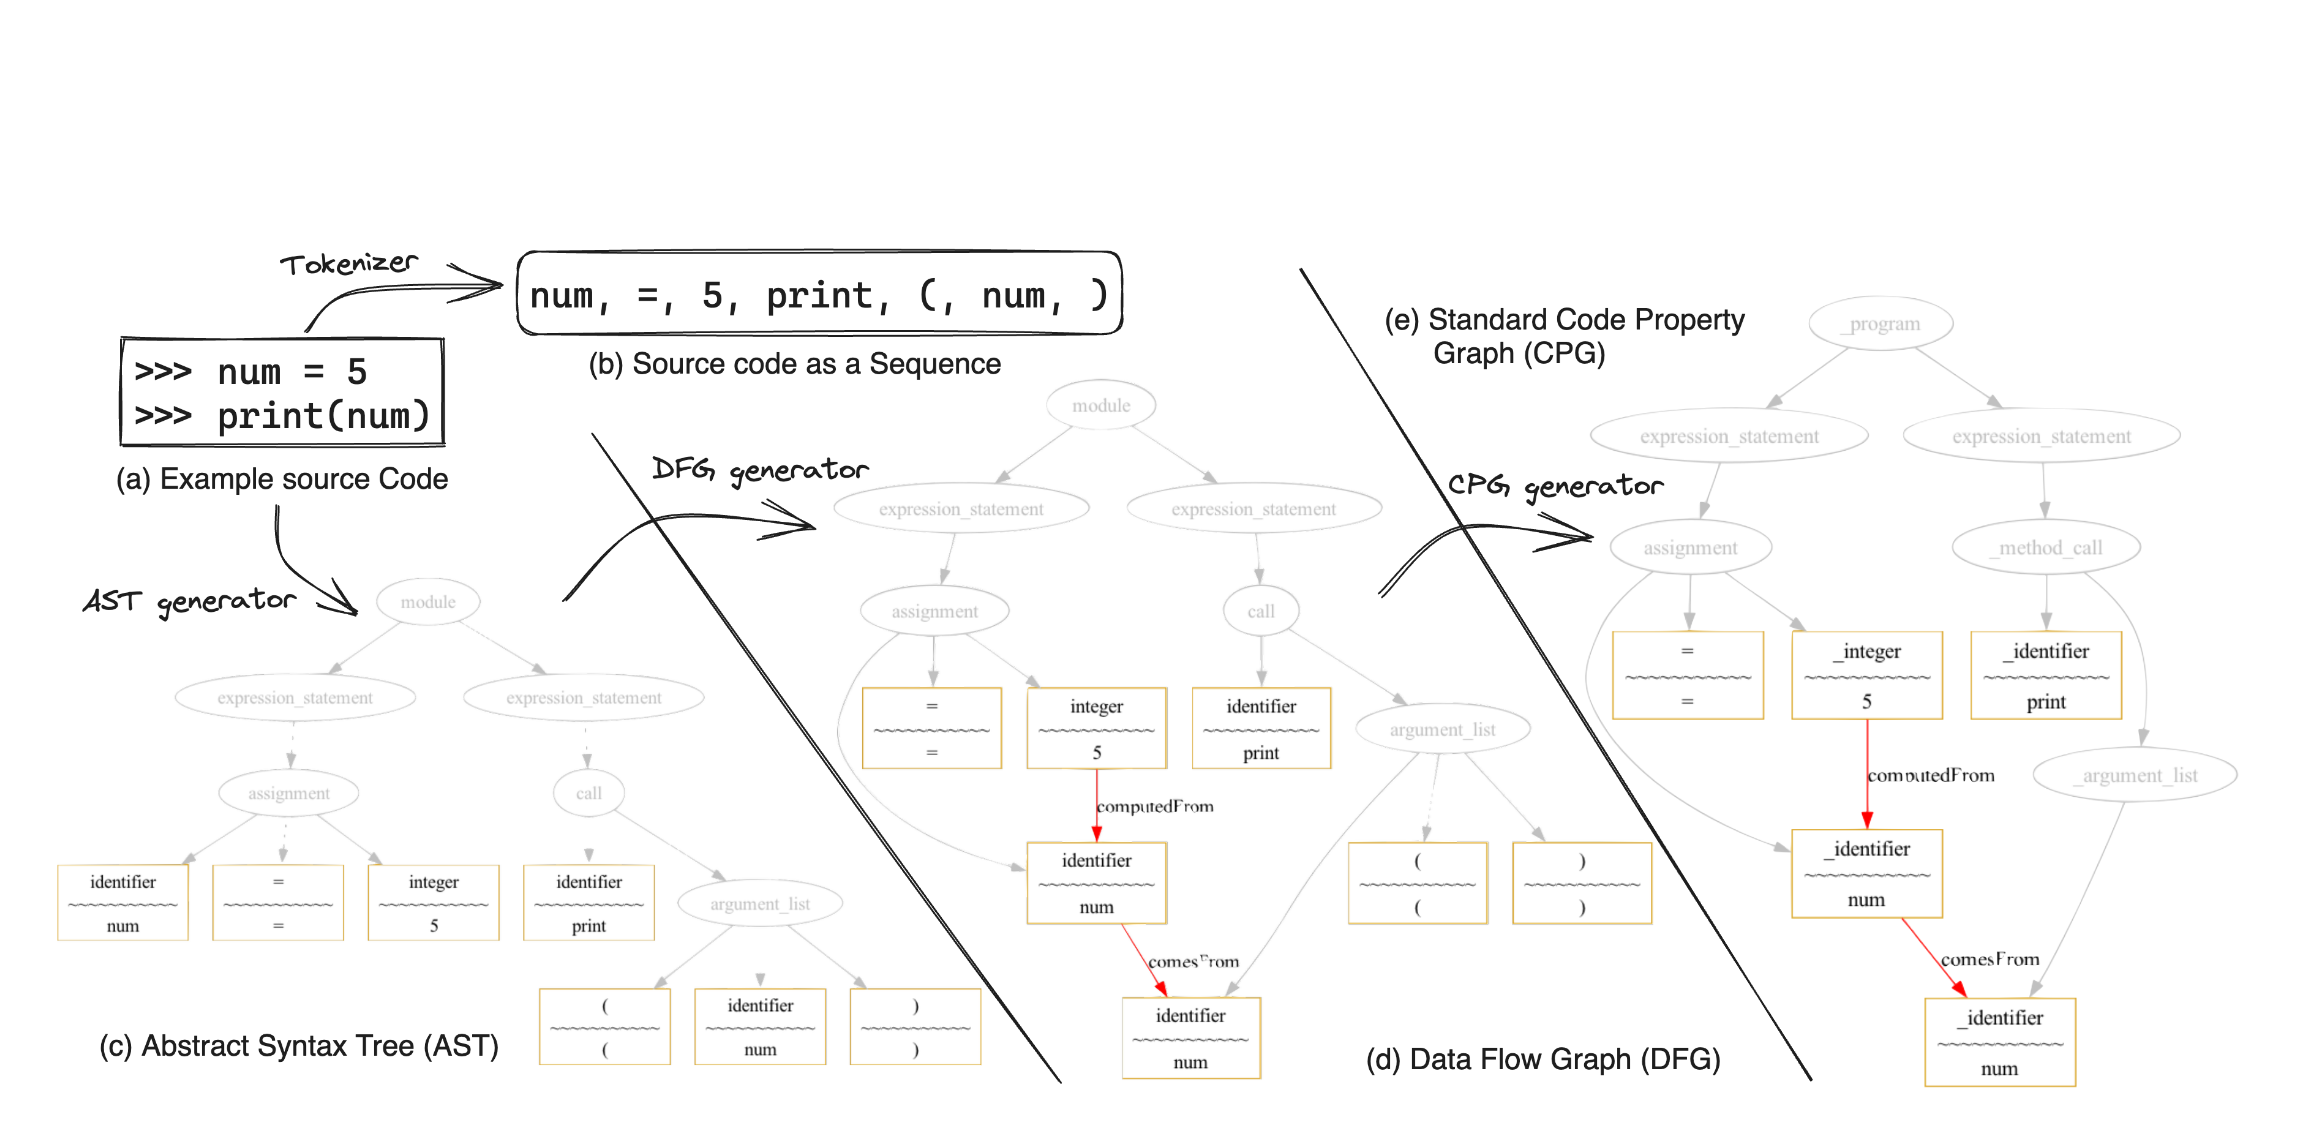